# Test multi-modal 2D
---
Description:

- Optimization (max)
- Multimodal (yes)
---

The equations are given by the Multivariate Normal Distribution, with **four** modes:

$f\left(\mathbf{x}\right) = \sum_{i=1}^{4}{\cal N}(\mu_i, \Sigma_i)$,

with mean vectors: $\mu_1 = [-0.0, -1.0]$, $\mu_2 = [-4.0, -6.0]$, $\mu_3 = [-5.0, +1.0]$, $\mu_4 = [5.0, -10.0]$,

and covariances: $\Sigma_1 = \begin{bmatrix} 1.0 & 0.1 \\ 0.1 & 1.0\end{bmatrix}$, 
$\Sigma_2 = \begin{bmatrix} 1.0 & 0.1 \\ 0.1 & 1.0\end{bmatrix}$, $\Sigma_3 = \begin{bmatrix} 1.2 & 0.3 \\ 0.3 & 1.2\end{bmatrix}$,
$\Sigma_4 = \begin{bmatrix} 1.2 & 0.3 \\ 0.3 & 1.2\end{bmatrix}$.

## First we import python libraries and set up the directory

In [1]:
import os, sys
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal

# Enable LaTex in plotting.
plt.rcParams["text.usetex"] = True

PROJECT_DIR = os.path.abspath("..")
sys.path.append(PROJECT_DIR)

## Here we import all our custom PSO code

In [2]:
from star_pso.auxiliary.swarm import Swarm
from star_pso.auxiliary.particle import Particle
from star_pso.engines.standard_pso import StandardPSO
from star_pso.auxiliary.utilities import cost_function

In [3]:
def lhs_sampler(n_samples: int, n_dims: int, lower: float = None, upper: float = None,
                criterion: str = None, iterations: int = 5, seed: int = None):
    """
    Latin Hypercube Sampling (LHS) using only numpy.

    Parameters
    - n_samples (int): number of samples (N)
    - n_dims (int): number of dimensions (D)
    - lower (array-like or scalar, optional): lower bounds per dimension (default 0)
    - upper (array-like or scalar, optional): upper bounds per dimension (default 1)
    - criterion (None or 'maximin'): if 'maximin', tries to maximize minimum pairwise distance
      using a simple iterative improvement (works well for moderate N, D)
    - iterations (int): iterations for 'maximin' improvement (default 5)
    - seed (int or None): random seed for reproducibility

    Returns
    - samples: ndarray of shape (n_samples, n_dims) with samples in [lower, upper]
    """
    rng = np.random.default_rng(seed)

    # Normalize bounds.
    if lower is None:
        lower = 0.0
        
    if upper is None:
        upper = 1.0
        
    lower = np.asarray(lower, dtype=float)
    upper = np.asarray(upper, dtype=float)
    
    if lower.shape == ():
        lower = np.full(n_dims, lower)
        
    if upper.shape == ():
        upper = np.full(n_dims, upper)
        
    if lower.shape != (n_dims,) or upper.shape != (n_dims,):
        raise ValueError("lower and upper must be scalars or arrays of length n_dims")
        
    if np.any(upper <= lower):
        raise ValueError("Each upper bound must be greater than lower bound")

    # 1) Generate the basic LHS in unit hypercube
    # For each dimension, create the N strata [0,1] split and pick a random point within each stratum,
    # then randomly permute strata assignments between samples.
    cut = np.linspace(0, 1, n_samples + 1)
    
    # random points in each stratum: shape (n_samples, n_dims)
    u = rng.random((n_samples, n_dims))
    
    points = np.empty((n_samples, n_dims))
    
    for j in range(n_dims):
        # strata lower bounds: cut[:n_samples], upper: cut[1:]
        pts_in_strata = cut[:n_samples] + u[:, j] * (1.0 / n_samples)
        
        # random permutation to assign strata to sample rows
        perm = rng.permutation(n_samples)
        
        points[:, j] = pts_in_strata[perm]
    # _end_for_

    # 2) Optional maximin improvement: try several random permutations
    #    and keep the one with largest min pairwise dist
    if criterion == "maximin" and iterations > 0:
        
        def min_pairwise_dist(x):
            # compute pairwise squared distances efficiently
            # x shape (n_samples, n_dims)
            sq = np.sum(x * x, axis=1, keepdims=True)
            d2 = sq + sq.T - 2 * (x @ x.T)
            # set diagonal to +inf to ignore zero distances
            np.fill_diagonal(d2, np.inf)
            return np.min(d2)
        # _end_def_
        
        best = points.copy()
        best_score = min_pairwise_dist(best)
        
        # try random swaps / permutations for each
        # dim independently for a few iterations
        for it in range(iterations):
            cand = np.empty_like(points)
            
            for j in range(n_dims):
                perm = rng.permutation(n_samples)
                # permute rows per-dimension
                cand[:, j] = points[perm, j]
            # _end_for_
            score = min_pairwise_dist(cand)
            if score > best_score:
                best_score = score
                best = cand
        # _end_for_
        points = best

    # 3) Scale to [lower, upper]
    samples = lower + points * (upper - lower)

    return samples

In [4]:
from collections import defaultdict

def count_particles_per_mode(x_pos: np.ndarray, modes: list,
                             radius: int = 1) -> dict:
    cppm = defaultdict(int)

    for px, py in x_pos:
        for vals in modes:
            cx, cy = vals
            if (px - cx)**2 + (py - cy)**2 <= radius**2:            
                cppm[tuple(vals)] += 1
                break
            # _end_if_
    # _end_for_
    return cppm
# _end_def_

## Setup the 2D functions

In [5]:
# Setup the 2D Gaussian functions.
# NOTE: Because of their covariance setup, the first two (mvn_1 and mvn_2)
# will have higher modes then the other two. So the maximum will be in one
# of these two modes.

# Each one with different mean and covariance matrix.
mvn_1 = multivariate_normal([-0.0, -1.0], [[1.0, 0.1], [0.1, 1.0]])

mvn_2 = multivariate_normal([-4.0, -6.0], [[1.0, 0.1], [0.1, 1.0]])

mvn_3 = multivariate_normal([-10.0, 5.0], [[1.2, 0.3], [0.3, 1.2]])

mvn_4 = multivariate_normal([5.0, -10.0], [[1.2, 0.3], [0.3, 1.2]])

# Define the negative log of the pdfs.
def negative_log_pdfx(x):
    return -np.log(mvn_1.pdf(x) + mvn_2.pdf(x) + mvn_3.pdf(x) + mvn_4.pdf(x))
# _end_def_

## Define the multi-modal function

In [6]:
@cost_function(minimize=True)
def fun_test2D(x: np.ndarray, **kwargs) -> float:
    
    # Compute the final value.
    f_value = negative_log_pdfx(x)
    
    # Return the solution.
    return f_value.item()
# _end_def_

## Here we set the PSO parameters

- Set the number of particles 'N'
- Setup the initial population
- Create the PSO object

In [7]:
# Random number generator.
rng = np.random.default_rng()

# Define the number of particles.
N = 75

# Draw random samples for the initial points.
X_t0 = rng.uniform(-15.0, 15.0, size=(N, 2))

# Draw samples using Latin Hyper Cube approach.
# X_t0 = lhs_sampler(N, n_dims=2, lower=-15.0, upper=15.0, iterations=50, criterion="maximin")

# Initial population.
swarm_t0 = Swarm([Particle(x) for x in X_t0])

# Create the StandardPSO object that will carry on the optimization.
test_PSO = StandardPSO(initial_swarm = swarm_t0, obj_func = fun_test2D,
                       x_min = -15.0, x_max = 15.0)

## Optimization process

In [8]:
test_PSO.run(max_it = 500,
             options = {"w0": 0.75, "c1": 1.85, "c2": 1.85, "mode": "multimodal"},
             reset_swarm = True, verbose = True, adapt_params = False)

Initial f_optimal = -2.2843
Iteration:     1 -> f_optimal = -2.0170
Iteration:    51 -> f_optimal = -1.8329
Iteration:   101 -> f_optimal = -1.8329
Iteration:   151 -> f_optimal = -1.8329
Iteration:   201 -> f_optimal = -1.8329
Iteration:   251 -> f_optimal = -1.8329
Iteration:   301 -> f_optimal = -1.8329
Iteration:   351 -> f_optimal = -1.8329
Iteration:   401 -> f_optimal = -1.8329
Iteration:   451 -> f_optimal = -1.8329
Final f_optimal = -1.8329
run: elapsed time = 6.754 seconds.


In [9]:
# Get the optimal solution from the PSO.
_, f_opt, x_opt = test_PSO.get_optimal_values()

# Print the resutls.
print(f"x={x_opt}, f(x) = {f_opt:.5f}")

x=[-2.67836573e-08 -1.00000003e+00], f(x) = -1.83285


In [10]:
best_n = []

for p in test_PSO.swarm.best_n(N):
    best_n.append(p.position)
    
best_n = np.unique(np.array(best_n), axis=0)

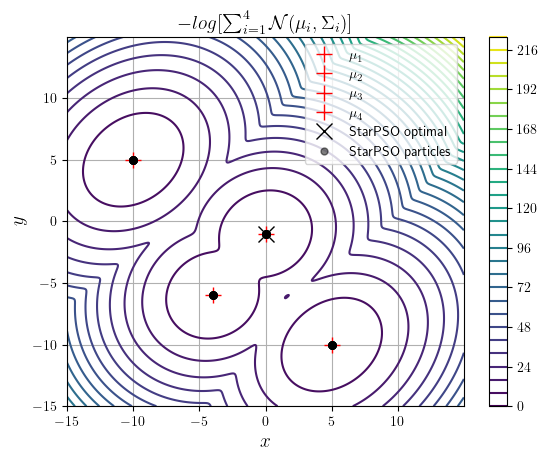

In [11]:
# Prepare the plot of the real density.
x, y = np.mgrid[-15:15:0.01, -15:15:0.01]

# Stack the position of the grid together.
pos = np.dstack((x, y))

# First plot the contour of the "true" function.
plt.contour(x, y, negative_log_pdfx(pos), levels=30)

# Add the three modes.
plt.plot(+0.0, -1.0, "r+", label="$\mu_1$", markersize=12)
plt.plot(-4.0, -6.0, "r+", label="$\mu_2$", markersize=12)
plt.plot(-10.0, 5.0, "r+", label="$\mu_3$", markersize=12)
plt.plot(5.0, -10.0, "r+", label="$\mu_4$", markersize=12)

# Plot the optimal PSO.
plt.plot(x_opt[0], x_opt[1], "kx", markersize=12, label="StarPSO optimal")

# Plot the best_n.
plt.plot(best_n[:, 0], best_n[:, 1], "ko", alpha=0.5, markersize=5, label="StarPSO particles")

# Add labels.
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14)
plt.title("$-log[\sum_{i=1}^4{\cal N}(\mu_i, \Sigma_i)]$", fontsize=14)
plt.legend()

# Final setup.
plt.colorbar()
plt.grid()

# Save to file.
plt.savefig("Multimodal_2D.pdf", format="pdf", dpi=300)

In [12]:
count_particles_per_mode(best_n, [[-0.0, -1.0],
                                  [-4.0, -6.0],
                                  [-10.0, 5.0],
                                  [5.0, -10.0]])

defaultdict(int,
            {(-10.0, 5.0): 21,
             (-4.0, -6.0): 15,
             (-0.0, -1.0): 21,
             (5.0, -10.0): 18})

### End of file